In [1]:
# !pip install gtts pydub audioop-lts
from gtts import gTTS
from pydub import AudioSegment
import time
import os
import pandas as pd
from datetime import date
import glob
from collections import defaultdict
from PIL import Image, ImageDraw, ImageFont
from moviepy import ImageClip, CompositeVideoClip, AudioFileClip
from pydub.exceptions import CouldntDecodeError
pd.options.display.max_columns = 100
pd.options.display.max_rows = 130
hanzi_font_path = '/System/Library/Fonts/STHeiti Medium.ttc'

# 0. Process raw article
https://m.huxiu.com/

https://www.lifeweek.com.cn/

http://www.news.cn/

In [142]:
news_ids = [
    '001', '002',
    # '003'
    ]
dfs_raw = {}
base_paths = {}
for news_id in news_ids:
    base_paths[news_id] = f'audio_files/news/{news_id}'
    dfs_raw[news_id] = pd.read_csv(f'{base_paths[news_id]}/article.txt', sep=';;')
    dfs_raw[news_id]['简体中文'] = dfs_raw[news_id]['简体中文'].str.replace('、', ', ').str.replace('，', ', ').str.replace('/', '-').str.strip()
    print(news_id, dfs_raw[news_id].shape)

    # Create folders for images and audio
    img_folder = f"{base_paths[news_id]}/img"
    if not os.path.exists(img_folder):
        os.mkdir(img_folder)
    audio_folder = f"{base_paths[news_id]}/audio"
    if not os.path.exists(audio_folder):
        os.mkdir(audio_folder)

dfs_raw[news_id].head()

001 (38, 3)
002 (31, 3)


/var/folders/z8/s7_mn6894xd5kj7pdpx6t6100000gn/T/ipykernel_24992/3930354667.py:9: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  dfs_raw[news_id] = pd.read_csv(f'{base_paths[news_id]}/article.txt', sep=';;')
/var/folders/z8/s7_mn6894xd5kj7pdpx6t6100000gn/T/ipykernel_24992/3930354667.py:9: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  dfs_raw[news_id] = pd.read_csv(f'{base_paths[news_id]}/article.txt', sep=';;')


,简体中文,拼音,英文翻译
0,"我是夜猫子体质, 晚上大脑非常活跃, 巅峰期大概在晚上九点到凌晨四点。","Wǒ shì yèmāozi tǐzhì, wǎnshàng dànǎo fēicháng ...",I am a night owl by nature; my brain is very a...
1,"而且我学习的前摇和后摇都比较长, 写论文时经常摇到晚上九点才开始写, 但效率是白天的好几倍。",Érqiě wǒ xuéxí de qián yáo hé hòu yáo dōu bǐji...,"Moreover, my pre-study and post-study preparat..."
2,"干不动了就睡, 大概中午十一点自然醒, 然后以吃顿好的, 买杯奶茶, 打明日方舟等方式开启施...","Gàn bù dòng le jiù shuì, dàgài zhōngwǔ shíyī d...","When I get too tired to work, I sleep, natural..."
3,"我是早起困难症患者, 一旦早起, 就戴上了痛苦面具。","Wǒ shì zǎoqǐ kùnnán zhèng huànzhě, yīdàn zǎoqǐ...",I am a chronic difficulty early riser; once I ...
4,"初中时学校管理模式比较宽松, 其实起得不算早, 但我每天都困得没有胃口吃早饭。",Chūzhōng shí xuéxiào guǎnlǐ móshì bǐjiào kuāns...,"In middle school, the management was relativel..."


# 1. TTS

In [143]:
for news_id in news_ids:
    total_start_time = time.time()
    for i_row, row in dfs_raw[news_id].iterrows():
        this_start_time = time.time()
        sent_audio_path = f"{base_paths[news_id]}/audio/{row['简体中文']}.mp3"
        if not os.path.exists(sent_audio_path):
            gTTS(row['简体中文'], lang='zh').save(sent_audio_path)
            print(f'{(time.time()-this_start_time):5.1f}s, {(time.time()-total_start_time):6.1f}s,{sent_audio_path}')
        else:
            print(f'{(time.time()-this_start_time):5.1f}s, {(time.time()-total_start_time):6.1f}s, ALREADY EXISTS ,{sent_audio_path}')


  2.3s,    2.3s,audio_files/news/001/audio/美国对印度征收50%关税, 印度能强硬抵抗多久？.mp3
  2.9s,    5.2s,audio_files/news/001/audio/8月27日, 美国对印度输美商品征收的25%额外关税正式生效, 这使美国对印度的总关税达到了惊人的50%, 成为美国征收关税税率最高的国家。.mp3
  0.0s,    5.2s, ALREADY EXISTS ,audio_files/news/001/audio/超高关税预计将对印度的出口造成沉重打击。.mp3
  2.6s,    7.8s,audio_files/news/001/audio/印度总理莫迪8月25日强硬表态称, 将支持印度小企业家和农民, 无论面临多大压力, 其领导的政府都将不断增强自身力量予以抵制。.mp3
  2.2s,   10.1s,audio_files/news/001/audio/印度外交部长苏杰生此前表示, 华盛顿要求印度停止购买俄罗斯原油“毫无道理”, 并指责西方国家虚伪, 因为欧洲与俄罗斯的贸易额远超印度。.mp3
  2.2s,   12.3s,audio_files/news/001/audio/美国是印度产品最大的出口市场, 去年, 美国对印度产品的进口额为870亿美元, 并出口420亿美元的商品。.mp3
  2.1s,   14.4s,audio_files/news/001/audio/美国从印度进口的主要商品包括药品, 通讯设备以及服装。.mp3
  2.6s,   17.0s,audio_files/news/001/audio/不过, 特朗普政府目前豁免了对来自印度的药品和电子产品等部分行业征收的额外关税, 原因是美国暂时无法解除在上述行业对印度产品的依赖。.mp3
  2.8s,   19.9s,audio_files/news/001/audio/据分析, 美国的最新关税将影响一半以上的印度产品出口。.mp3
  2.7s,   22.5s,audio_files/news/001/audio/《纽约时报》指出, 三分之二的美国大企业在印度设有海外业务。.mp3
  2.5s,   25.0s,audio_files/news/001/audio/美国对印度征收高额关税将打

# 2. Combine individual sentence audio

In [144]:
pause_500ms = AudioSegment.silent(duration=500)
dfs_dur = {}

for news_id in news_ids:
    total_start_time = time.time()
    all_audio_files = []
    audio_durations = []
    for i_row, row in dfs_raw[news_id].iterrows():
        start_time = time.time()
        sent_audio_path = f"audio_files/news/{news_id}/audio/{row['简体中文']}.mp3"
        row_audio = AudioSegment.from_mp3(sent_audio_path)
        audio_durations.append(row_audio.duration_seconds)
        all_audio_files.append(row_audio)
        all_audio_files.append(pause_500ms)

    dfs_dur[news_id] = dfs_raw[news_id].copy()
    dfs_dur[news_id]['duration'] = audio_durations
    dfs_dur[news_id]['dur_with_pause'] = dfs_dur[news_id]['duration'] + 0.5
    dfs_dur[news_id]['cumsum'] = dfs_dur[news_id]['dur_with_pause'].cumsum()
    dfs_dur[news_id]['start_time'] = dfs_dur[news_id]['cumsum'] - dfs_dur[news_id]['dur_with_pause']

    full_audio_path = f"audio_files/news/{news_id}/full_audio.mp3"
    combined = all_audio_files[0]
    for audio in all_audio_files[1:]:
        combined += audio
    combined.export(full_audio_path, format="mp3")
    print(f"{(time.time()-total_start_time):.2f}s, {news_id}, {dfs_dur[news_id]['duration'].sum():.1f}s, {full_audio_path}")

dfs_dur[news_id].head()

5.03s, 001, 520.9s, audio_files/news/001/full_audio.mp3
3.71s, 002, 355.5s, audio_files/news/002/full_audio.mp3


,简体中文,拼音,英文翻译,duration,dur_with_pause,cumsum,start_time
0,"我是夜猫子体质, 晚上大脑非常活跃, 巅峰期大概在晚上九点到凌晨四点。","Wǒ shì yèmāozi tǐzhì, wǎnshàng dànǎo fēicháng ...",I am a night owl by nature; my brain is very a...,10.104,10.604,10.604,0.000
1,"而且我学习的前摇和后摇都比较长, 写论文时经常摇到晚上九点才开始写, 但效率是白天的好几倍。",Érqiě wǒ xuéxí de qián yáo hé hòu yáo dōu bǐji...,"Moreover, my pre-study and post-study preparat...",12.696,13.196,23.800,10.604
2,"干不动了就睡, 大概中午十一点自然醒, 然后以吃顿好的, 买杯奶茶, 打明日方舟等方式开启施...","Gàn bù dòng le jiù shuì, dàgài zhōngwǔ shíyī d...","When I get too tired to work, I sleep, natural...",16.632,17.132,40.932,23.800
3,"我是早起困难症患者, 一旦早起, 就戴上了痛苦面具。","Wǒ shì zǎoqǐ kùnnán zhèng huànzhě, yīdàn zǎoqǐ...",I am a chronic difficulty early riser; once I ...,7.464,7.964,48.896,40.932
4,"初中时学校管理模式比较宽松, 其实起得不算早, 但我每天都困得没有胃口吃早饭。",Chūzhōng shí xuéxiào guǎnlǐ móshì bǐjiào kuāns...,"In middle school, the management was relativel...",10.728,11.228,60.124,48.896


# 3. Create images for video

0
001; Audio vs Video: 540.00s; 34.72s
0
002; Audio vs Video: 371.09s; 40.93s



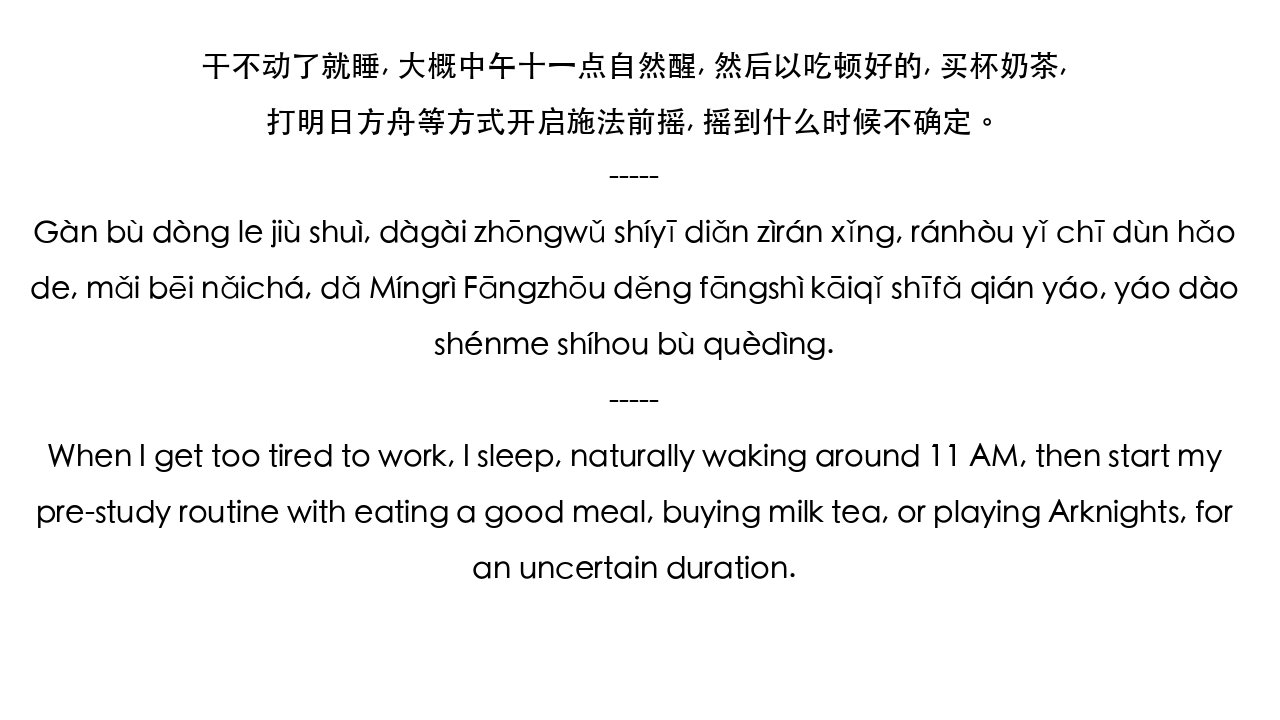

In [145]:
def get_wrapped_text(text: str, font: ImageFont.ImageFont, line_length: int):
    # TODO: improve this for long strings of chinese characters without spaces
    new_lines = ['']
    for original_line in text.split('\n'):

        # Make sure no words are longer than line_length in original line
        # if so, divide it into multiple words to make a new line
        words_split = original_line.split(' ')
        no_long_words_line = ''
        for word in words_split:
            if font.getlength(word) > line_length:
                print(font.getlength(word), word)
                # Split the word into characters
                long_word_chars = list(word)
                new_long_word = ''
                tmp_long_word = ''
                for char in long_word_chars:
                    test_word = f'{tmp_long_word}{char}'
                    if font.getlength(test_word) <= line_length:
                        tmp_long_word = f'{tmp_long_word}{char}'
                    else:
                        new_long_word += f'{tmp_long_word} '
                        tmp_long_word = ''
                no_long_words_line += f'{new_long_word}{tmp_long_word}'
            else:
                no_long_words_line += f'{word} '

        words_split = no_long_words_line.split(' ')
        for word_idx, word in enumerate(words_split):
            test_line = f'{new_lines[-1]} {word}'.strip()
            if word_idx == 0 and new_lines[-1] != '':
                new_lines.append(word)
            elif font.getlength(test_line) <= line_length:
                new_lines[-1] = test_line
            else:
                new_lines.append(word)
    return '\n'.join(new_lines)


def create_text_clip(
        text, duration, timestamp_start, image_file_name
        , size=(1280, 720)
        , bg_color='white'
        , text_color='black'
        ):
    font = ImageFont.truetype(hanzi_font_path, 30)
    wrapped_text = get_wrapped_text(text, font, line_length=size[0]-60)

    img = Image.new("RGB", size, color=bg_color)
    draw = ImageDraw.Draw(img)
    draw.multiline_text(
        xy=(30, 50), text=wrapped_text, font=font
        , fill=text_color, spacing=30, align='center'
        )
    img.save(image_file_name)
    return ImageClip(image_file_name, duration=duration).with_start(timestamp_start)
    
clips = {}
for news_id in news_ids:
    clips[news_id] = []
    for idx, row in dfs_dur[news_id].iterrows():
        img_txt = f"{row['简体中文']}\n-----\n{row['拼音']}\n-----\n{row['英文翻译']}"
        img_path = f"{base_paths[news_id]}/img/{row['简体中文']}.png"
        clips[news_id].append(create_text_clip(img_txt, row['dur_with_pause'], row['start_time'], img_path))
        if idx % 10 == 0:
            print(idx)
        if idx == 2:
            break

    # Compare durations of audio and video
    audio = AudioFileClip(f"{base_paths[news_id]}/full_audio.mp3")
    all_clips_duration = sum(clip.duration for clip in clips[news_id])
    print(f"{news_id}; Audio vs Video: {audio.duration:.2f}s; {all_clips_duration:.2f}s")

clips[news_id][-1].display_in_notebook()

# 4. Create video

In [ ]:
for news_id in news_ids:
    video_path = f"{base_paths[news_id]}/full_video.mp4"
    if not os.path.exists(video_path):
        print(f"Creating video for {news_id}")
        # Combine clips
        video = CompositeVideoClip(clips[news_id], size=(1280,720))
        audio = AudioFileClip(f"{base_paths[news_id]}/full_audio.mp3")
        video.audio = audio
        video.duration = audio.duration

        # Export video
        video.write_videofile(video_path, fps=24)
        print(f"{news_id} video saved to {video_path}")
    else:
        print(f"Video already exists for {news_id}: {video_path}")

Creating video for 001


frame_index:  16%|█▋        | 2976/18230 [23:49<03:50, 66.16it/s, now=None]

MoviePy - Building video audio_files/news/001/full_video.mp4.
MoviePy - Writing audio in full_videoTEMP_MPY_wvf_snd.mp3


frame_index:  16%|█▋        | 2976/18230 [23:51<03:50, 66.16it/s, now=None]

MoviePy - Done.
MoviePy - Writing video audio_files/news/001/full_video.mp4

